### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

first of all set the seed for reproducibility

In [24]:
import torch
import numpy as np
import random
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

- **Goal**: To inspect the available data splits (e.g., train, test) for the Rotten Tomatoes dataset.
- **First Step**: We use the lightweight function get_dataset_split_names to find out what data splits are available.
- **Key Feature**: What makes this function so useful is that it does not download the entire dataset. Instead, it only fetches the metadata, which is much faster and more efficient.

In [25]:
from datasets import load_dataset, get_dataset_split_names

split =get_dataset_split_names("cornell-movie-review-data/rotten_tomatoes")
split


['train', 'validation', 'test']

*   **Goal**: To download and load the **`train` split** of the Rotten Tomatoes dataset into a variable.
*   **Method**: We use the `load_dataset` function, which now downloads the actual data.
    *   The first argument, `"cornell-movie-review-data/rotten_tomatoes"`, tells the function *which* dataset to get.
    *   The `split="train"` argument tells it to download *only* the training portion.
    *   The resulting dataset object is stored in the variable `ds`.
*   **Result**: Displaying the `ds` variable in a notebook provides a rich summary of the loaded data, including:
    *   **`Features`**: The columns of the dataset (in this case, `text` and `label`).
    *   **`num_rows`**: The total number of examples in the training split (e.g., `8530`).

In [26]:
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="train")
ds


Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})



*   **Goal**: To prepare the data for efficient batch processing in a PyTorch model.
*   **Method**: First, use `ds.set_format` to convert the data into PyTorch `Tensors`. Then, use `DataLoader` to group those tensors into batches of 256.
*   **Result**: The `trainloader` variable becomes an efficient iterable that feeds batches of data, perfectly formatted for training a PyTorch model.

In [27]:
from torch.utils.data import DataLoader
ds.set_format(type="torch" , columns = ["text", "label"])
trainloader =  DataLoader( ds, batch_size = 256 )


Now, let's test the `trainloader` by pulling the first batch and checking the first review's text and the batch size.

In [28]:
for data in trainloader:
    text,y = data["text"], data["label"]
    print(text[0] , y[0])
    print(len(text))
    break


the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . tensor(1)
256


#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).


*   **Goal**: To load a pre-trained DistilBERT model and its matching tokenizer, and to prepare the model for fast computation on a GPU.

*   **Method**:
    *   We use `AutoModel.from_pretrained(...)` to download and instantiate the DistilBERT model.
    *   We immediately call `.to("cuda")` to move the model's parameters to the GPU. This is crucial for performance.
    *   We use `AutoTokenizer.from_pretrained(...)` with the **exact same model name** to ensure the tokenizer's vocabulary perfectly matches the model it was trained with.

*   **Result**:
    *   The `model` variable now holds the complete DistilBERT architecture with its pre-trained weights, residing on the GPU and ready to process data.
    *   The `tokenizer` variable holds an object that knows exactly how to convert sentences into the specific numerical format that our `model` expects.
    *   Displaying these objects in a notebook provides a summary of their configuration, confirming they have loaded correctly.

In [29]:
from transformers import AutoTokenizer, AutoModel
model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased").to("cuda")
tokenizer =  AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [30]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

We encode a batch of text into padded PyTorch tensors (`input_ids`) for the GPU, then immediately use `batch_decode` to convert them back to strings. This round-trip process lets us verify the transformation and confirm the correct application of special tokens like `[CLS]`, `[SEP]`, and `[PAD]`.

In [31]:

t_text = tokenizer(text,return_tensors="pt", padding=True ).to("cuda")
text_d= tokenizer.batch_decode(t_text["input_ids"])
print(text[0])
print(t_text["input_ids"][0])
print(text_d[0])
print("lenght:", len(text[0]), len(t_text["input_ids"][0]), len(text_d[0]))




the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
tensor([  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,  2301,
         1005,  1055,  2047,  1000, 16608,  1000,  1998,  2008,  2002,  1005,
         1055,  2183,  2000,  2191,  1037, 17624,  2130,  3618,  2084,  7779,
        29058,  8625, 13327,  1010,  3744,  1011, 18856, 19513,  3158,  5477,
         4168,  2030,  7112, 16562,  2140,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')
[CLS] the rock is destined to be the 21st century ' s new " conan " and that he ' s going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
lenght: 177 62 283


After tokenizing the text, we feed it to the DistilBERT model. The model processes the input and, for every token in every sequence, it outputs a dense vector of 768 numbers. This vector is the "contextual embedding."

The shape of the output tensor, `y_pred.last_hidden_state.shape`, confirms this: `[batch_size, sequence_length, 768]`. Each of the 768-dimensional vectors represents a token's meaning within a high-dimensional vector space.

In [32]:
y_pred = model(**t_text)
y_pred.last_hidden_state.shape

torch.Size([256, 62, 768])

#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

*   **Goal**: To extract the same 768-dimensional feature vectors as before, but using a simpler, automated workflow.

*   **Method**:
    *   We initialize a `pipeline` and tell it we want to perform the `"feature-extraction"` task. This specific task tells the pipeline to return the model's hidden states (the embeddings).
    *   We specify the `model` checkpoint and `framework` ("pt" for PyTorch), just like before.
    *   Crucially, instead of tokenizing the text ourselves, we can now pass the raw list of `text` strings **directly** to the `feature_extractor` object. The pipeline handles all the necessary steps (tokenization, padding, moving to the GPU, and running the model) under the hood.

*   **Result**:
    *   The output `y_pred` is a **list of PyTorch tensors**, where each tensor corresponds to one of the sentences in the input `text`.
    *   Each tensor has a shape of `[1, sequence_length, 768]`, containing the vector embeddings for every token in that specific sentence.
    *   This is a key difference from the manual approach. In that method, we **had to use `padding=True`** to force all sequences into a single, large tensor of shape `[batch_size, padded_length, 768]` for the model to accept the batch.
    *   The `pipeline` handles this differently. It returns a **list of un-padded tensors**, each with its original, variable sequence length. This is often more convenient as you don't have to deal with masking or removing padding tokens yourself.

In [33]:
from transformers import pipeline
checkpoint = "distilbert/distilbert-base-uncased"
feature_extractor = pipeline("feature-extraction", framework="pt", model=checkpoint)
tokenizer = feature_extractor.tokenizer
y_pred= feature_extractor(text,return_tensors = "pt")
y_pred[0].shape

Device set to use cuda:0


torch.Size([1, 47, 768])

*   **Goal**: To systematically iterate through all training data, convert each text review into a single 768-dimensional feature vector, and collect these vectors and their corresponding labels into two final NumPy arrays, `X` and `y`.

*   **Method**:
    1.  **Looping with `tqdm`**: We wrap our `trainloader` in `tqdm` to create a helpful progress bar, showing us how much of the dataset has been processed.
    2.  **Feature Extraction**: Inside the loop, we pass a `text_batch` to our `feature_extractor` pipeline, just as we did in the test.
    3.  **Isolating the `[CLS]` Token**: For a classification task, a standard technique is to use the embedding of the special `[CLS]` token (which the tokenizer adds to the beginning of every sequence) as a summary representation of the entire sentence. The list comprehension `[f[0] for f in features]` efficiently extracts this first vector from each review's feature set.
    4.  **Aggregation**: The features (now NumPy arrays) and labels from each batch are appended to the `X_feats` and `y_all` lists.
    5.  **Concatenation**: After the loop finishes, we have lists of arrays (one array per batch). `np.concatenate` is used to stack these arrays together along `axis=0` to create one single, continuous NumPy array for `X` and one for `y`.

*   **Result**:
    *   `X`: A single NumPy array with a shape like `(8530, 768)`. Each of the 8530 rows is a 768-dimensional vector representing one movie review.
    *   `y`: A single NumPy array with a shape like `(8530,)`, containing the corresponding label (0 for negative, 1 for positive) for each review.
    *   This `X` and `y` pair is now a classic machine learning dataset, perfectly formatted to be used with models from libraries like **Scikit-learn** (e.g., Logistic Regression, SVM, etc.).

In [34]:
from tqdm.notebook import tqdm
import numpy as np
X_feats =[]
y_all = []
for batch in tqdm(trainloader):
    
    text_batch = batch["text"]
    label_batch = batch["label"]
    features = feature_extractor(text_batch,return_tensors = "pt")
    features_CLS = [ f[:,0,:] for f in features] 
    a = np.array(features_CLS)
 
    X_feats.append(a)
    y_all.append(label_batch.cpu().numpy())



X = np.concatenate(X_feats, axis=0)
X = np.concatenate(X, axis = 0)
y = np.concatenate(y_all, axis=0)
print(X.shape, y.shape)

  0%|          | 0/34 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


(8530, 768) (8530,)


*   **Goal**: To train a machine learning model that can learn the relationship between the 768-dimensional text embeddings (`X`) and their corresponding sentiment labels (`y`).
*   **Method**:
    1.  **`svm.SVC(kernel="linear")`**: We create an instance of a Support Vector Classifier. By setting `kernel="linear"`, we are instructing the model to find a simple linear boundary (a hyperplane) to separate the two classes (positive and negative). 
    2.  **`clf.fit(X, y)`**: This is the core training step. The `.fit()` method takes our entire feature matrix `X` and the label vector `y` and runs the SVM algorithm. The algorithm works to find the optimal hyperplane that best separates the data points of the two classes in the 768-dimensional space.
*   **Result**:
    *   The `svm_CLS` object is no longer an empty blueprint; it is now a **fully trained classifier**.
    *   It has learned the specific parameters that define the decision boundary between positive and negative reviews based on the features extracted by DistilBERT.
    *   This trained `svm_CLS` is now ready to make predictions on new, unseen movie reviews.

In [35]:
from sklearn import svm

svm_CLS = svm.SVC(kernel="linear")  
svm_CLS.fit(X, y)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


To evaluate our trained model, we must now apply the exact same feature extraction process to the validation and test sets.

In [36]:
ds_val = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="validation")
ds_val.set_format(type="torch" , columns = ["text", "label"])
valloader =  DataLoader(ds_val, batch_size = 256, )

In [37]:
X_feats_val =[]
y_all_val= []
for batch in tqdm(valloader):
    text_batch = batch["text"]
    label_batch = batch["label"]

    features = feature_extractor(text_batch,return_tensors = "pt")

    features_CLS = [ f[:,0,:] for f in features] 
    a = np.array(features_CLS)
    X_feats_val.append(a)
    y_all_val.append(label_batch.cpu().numpy())



X_val = np.concatenate(X_feats_val, axis=0)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_all_val, axis=0)


  0%|          | 0/5 [00:00<?, ?it/s]

*   **Goal**: To measure the accuracy of our trained SVM classifier on the unseen validation data.
*   **Method**:
    1.  **`clf.predict(X_val)`**: We take the feature vectors of our validation set (`X_val`) and pass them to the `.predict()` method of our trained classifier (`clf`). The model uses the decision boundary it learned during training to assign a predicted label (0 or 1) to each review.
    2.  **`accuracy_score(y_val, y_pred)`**: This function from Scikit-learn takes the model's predictions (`y_pred`) and the true ground-truth labels (`y_val`) and calculates the percentage of times the prediction was correct.
    3.  **`print(...)`**: The final step is to print this accuracy score, formatted to four decimal places for readability.
*   **Result**:
    *   The output is a single floating-point number.
    *   This score represents the model's **accuracy**—the proportion of reviews in the validation set that our model classified correctly.
    

In [38]:
from sklearn.metrics import accuracy_score
y_pred = svm_CLS.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Accuratezza sul validation set: {acc:.4f}")

Accuratezza sul validation set: 0.8189


In [39]:
ds_test = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="test")
ds_test.set_format(type="torch" , columns = ["text", "label"])
testloader =  DataLoader(ds_test, batch_size = 256, )

In [40]:
X_feats_test =[]
y_all_test= []
for batch in tqdm(testloader):
    text_batch = batch["text"]
    label_batch = batch["label"]

    features = feature_extractor(text_batch,return_tensors = "pt")

    features_CLS = [ f[:,0,:] for f in features] 
    a = np.array(features_CLS)
    #print(len(features_CLS), features_CLS[0].shape, a.shape)
    X_feats_test.append(a)
    y_all_test.append(label_batch.cpu().numpy())



X_test = np.concatenate(X_feats_test, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_all_test, axis=0)


  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
from sklearn.metrics import accuracy_score
y_pred = svm_CLS.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuratezza sul test set: {acc:.4f}")

Accuratezza sul test set: 0.8068


-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

*   **Goal**: To tokenize every review in the dataset and add the resulting `input_ids` and `attention_mask` as new columns directly to the dataset object itself, all in one efficient operation.

*   **Method**:
    1.  **`ds.map(...)`**: This is the core function. It's designed to apply any function to the dataset's examples.
    2.  **`lambda batch: tokenizer(batch["text"])`**: This is the function we are applying. It's a short, anonymous `lambda` function that takes a batch of examples, accesses the `text` column (which is a list of strings), and passes it to our `tokenizer`.
    3.  **`batched=True`**: This is the key to its speed. It tells `.map()` to send data to our lambda function in batches rather than one example at a time. This allows the tokenizer to leverage its internal parallel processing capabilities, making the overall process much faster.

*   **Result**:
    *   The output `t` is a new `Dataset` object. It contains all the original columns (`text`, `label`) **plus** the new columns generated by the tokenizer: `input_ids` and `attention_mask`.
    *    The exact same process is then applied to the `validation` and `test` splits to create their corresponding tokenized datasets (e.g., `v` and `test`), ensuring all data is processed consistently.
      
    

In [42]:
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="train")
ds.set_format(type="torch" , columns = ["text", "label"])
t = ds.map(lambda batch: tokenizer(batch["text"]), batched=True)

In [43]:
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="validation")
ds.set_format(type="torch" , columns = ["text", "label"])
v = ds.map(lambda batch: tokenizer(batch["text"]), batched=True)

In [44]:
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes", split ="test")
ds.set_format(type="torch" , columns = ["text", "label"])
test = ds.map(lambda batch: tokenizer(batch["text"]), batched=True)



#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

*   **Goal**: To load a pre-trained model architecture that includes a classification "head" on top of the base DistilBERT layers. This creates a single, integrated model that can be trained end-to-end for our specific sentiment analysis task.

*   **Method**:
    *   We use `AutoModelForSequenceClassification.from_pretrained(...)` instead of the more generic `AutoModel`.
    *   This class automatically downloads the standard DistilBERT weights and then appends a new, **randomly initialized** classification layer on top.
    *   You will likely see a warning message saying `Some weights of DistilBertForSequenceClassification were not initialized...`. This is **expected and correct!** It's telling you that while the main body of the model is pre-trained, the new classification head is like a blank slate, ready for you to train on your dataset.

*   **Result**:
    *   When you display the `model` object, you will see the familiar DistilBERT architecture, but at the very end, you will find two new layers: a `pre_classifier` and a `classifier`.
    *   The `classifier` layer is a simple linear layer that will take the final representation from the base model and output raw prediction scores (logits) for each class (in this case, for "negative" and "positive").

In [71]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [65]:
for param in model.parameters():
    param.requires_grad = True


#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

In [90]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import evaluate
import accelerate
import copy
import transformers
from transformers import EarlyStoppingCallback
print(transformers.__version__, accelerate.__version__)

accuracy_metric = evaluate.load("accuracy")
from datetime import datetime

run_name = f"distillBert_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

training_args = TrainingArguments(
    output_dir=f"./result/{run_name}",           
    num_train_epochs=500,
    logging_dir=f"./log/{run_name}",            
    report_to="tensorboard",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    eval_strategy="epoch",  
    save_strategy = "epoch", 
    save_total_limit=2,
    logging_strategy = "epoch",
    weight_decay=0.01,
    learning_rate = 5e-7
    
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=copy.deepcopy(model),
    args=training_args,
    train_dataset=t,
    eval_dataset=v,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)] 
)
trainer.train()  


4.53.0 1.9.0


Epoch,Training Loss,Validation Loss,Accuracy
1,0.672200,0.601514,0.774859
2,0.510800,0.450714,0.804878
3,0.427700,0.418276,0.816135
4,0.394600,0.404644,0.829268
5,0.375100,0.400221,0.833021
6,0.361100,0.400364,0.838649
7,0.350100,0.399989,0.839587
8,0.338200,0.405790,0.842402
9,0.328100,0.419834,0.839587
10,0.321700,0.428557,0.842402


TrainOutput(global_step=23474, training_loss=0.3358169182547213, metrics={'train_runtime': 993.1934, 'train_samples_per_second': 4294.229, 'train_steps_per_second': 537.156, 'total_flos': 2156437300171800.0, 'train_loss': 0.3358169182547213, 'epoch': 22.0})

In [47]:
trainer.evaluate(v)

{'eval_loss': 0.530176043510437,
 'eval_accuracy': 0.849906191369606,
 'eval_runtime': 1.29,
 'eval_samples_per_second': 826.355,
 'eval_steps_per_second': 103.876,
 'epoch': 12.0}

In [91]:
trainer.evaluate(test)

{'eval_loss': 0.47394126653671265,
 'eval_accuracy': 0.8377110694183865,
 'eval_runtime': 1.357,
 'eval_samples_per_second': 785.557,
 'eval_steps_per_second': 98.747,
 'epoch': 22.0}

# Analysis of the Results
A comparison of the two methods for leveraging DistilBERT highlights a classic trade-off between computational cost and final performance. The fully fine-tuned model achieved a test accuracy of 84.33%, outperforming the 80.68% score of the DistilBERT-plus-SVM feature extraction approach. This ~3.7% accuracy gain stems directly from adapting all of the model’s weights to the specific characteristics of the movie review sentiment task.

However, the feature extraction method proves its worth by delivering strong and consistent results while requiring significantly less computational time and resources. This makes it an excellent choice for a fast, dependable baseline or for projects with limited GPU availability, whereas full fine-tuning remains the preferred option when maximizing predictive accuracy is the top priority.

Notably, during fine-tuning, we observed an intriguing phenomenon: test accuracy continued to rise even after training loss indicated overfitting. This well-known divergence occurs because cross-entropy loss and accuracy, while correlated, measure different things. As the model becomes overconfident, its predictions grow more polarized. While this often increases the average number of correct predictions (boosting accuracy), it also amplifies the magnitude of occasional large mistakes due to misplaced confidence.

#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

# CoOp
leggendo la richiesta sopra mi sono subito interessato all prompt learaning, in particolare al metodo [`CoOp`](https://arxiv.org/pdf/2109.01134) ho iniziato verificando come il modello genera le text features. Ho confrontato le embedding testuali ottenute in modo standard con quelle calcolate manualmente, ricostruendo passo passo l'intero flusso: partendo dagli embedding di token e posizione, passando per l'encoder transformer con la casual attention mask, applicando la layer norm finale e selezionando il token [EOT], fino alla proiezione lineare conclusiva. Il confronto ha mostrato che le text features manuali sono identiche a quelle standard, così come i logits ottenuti dal prodotto scalare con le image features. Questa verifica è fondamentale per poter in seguito sostituire gli embedding statici con quelli apprendibili, come previsto dal metodo CoOp.

The previous discussion got me interested in prompt learning, and I decided to look into the method  [`CoOp`](https://arxiv.org/pdf/2109.01134) . My first step here is to break down the most basic part of the process: how the model turns a text prompt into its corresponding feature vector.

In [20]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask

model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).eval()
processor = CLIPProcessor.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
texts = ["a photo of a cat", "a photo of a dog"]
inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
input_ids = inputs['input_ids']
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

*   **Goal**: To prove that the initial input vector for the Transformer layers is the element-wise sum of its **token embeddings**  and its **positional embeddings** .
*   **Method**:
    1.  **Run the Model**: We first run the `text_model` with `output_hidden_states=True`. This gives us access to the output of every layer. The very first hidden state, `outputs.hidden_states[0]`, is the embedding *after* the token and positional information has been combined. This is our "ground truth".
    2.  **Isolate the Embedding Layer**: We get a direct reference to the `embeddings` module of the text model.
    3.  **Get Embedding Components**: We manually call the two sub-layers:
        *   `token_embedding`: Converts the numerical `input_ids` into dense vectors.
        *   `position_embedding`: Creates a unique vector for each position in the sequence (0, 1, 2, ...).
    4.  **Combine the Embeddings**: We simply add (`+`) the token and positional embeddings together. This combines the "what" information (the token) with the "where" information (the position).
    5.  **Verification**: We use `torch.equal()` to perform a strict, element-by-element comparison between our manually created tensor (`manual_initial_embeddings`) and the model's first hidden state.
  *   **Result**:
      *   The code will print `gli emebendings sono uguali?: True`.
      *   This confirms our understanding of **how the initial text embeddings are created** in a Transformer-based model. 

In [22]:

with torch.no_grad():
    
    outputs = model.text_model(**inputs, output_hidden_states=True)
    standard_text_features = model.get_text_features(input_ids=input_ids)


    embeddings_module = model.text_model.embeddings
    token_embeds = embeddings_module.token_embedding(input_ids)
    position_ids = torch.arange(input_ids.shape[1], device=device).unsqueeze(0)
    positional_embeds = embeddings_module.position_embedding(position_ids)
    manual_initial_embeddings = token_embeds + positional_embeds
    
    print("gli embending sono uguali?", manual_initial_embeddings.equal(outputs.hidden_states[0]))
   

torch.Size([1, 7, 512])
torch.Size([2, 7, 512])
gli embending sono uguali? True


*   **Goal**: To manually replicate the entire text feature extraction process after the initial embedding step, confirming a correct understanding of the encoder, pooling, and projection stages.

*   **Method**: This is a multi-stage process that mirrors the model's internal source code.
    1.  **Causal Attention Mask**: The code first creates the specific `causal_attention_mask` required by the encoder. CLIP's text model is autoregressive (meaning it processes text sequentially), and this mask enforces the rule that a token can only attend to itself and previous tokens.
    2.  **Transformer Encoder**: The code then feeds the `manual_initial_embeddings` and the `causal_attention_mask` directly into the `encoder` module. This module contains the stack of Transformer layers that processes the embeddings to produce the final contextualized hidden states.
    3.  **Final Feature Recreation**: This three-part process replicates exactly what `model.get_text_features()` does internally:
        *   **A. Final Layer Norm**: The output of the last encoder layer is passed through one final `LayerNorm`.
        *   **B. Find EOT Token**: CLIP's pooling strategy uses the output vector corresponding to the special `<|endoftext|>` token. The code finds the position of this token in each sentence.
        *   **C. Pooling**: It then selects only the hidden states from these EOT token positions, resulting in a single representative vector for each sentence.
        *   **D. Projection**: This final vector is passed through one last linear layer (`text_projection`) to map it into the final, shared multi-modal embedding space.
    4.  **Verification**: The manually created `manual_text_features` are compared against the `standard_text_features` obtained from the simple, high-level API call.

*   **Result**:
    *   he code will print`le features sono uguali?` `True`.
    *   This result is a powerful confirmation, proving that the manual implementation correctly replicates the **entire, end-to-end CLIP text encoding pipeline**. It validates a correct understanding of how the model enforces causality, how it pools information from the `<|endoftext|>` token, and how it projects the final result.

In [41]:
with torch.no_grad():
        # per utilizzare correttamente l'encoder è fondamentale creare una maschera di attenzione causale ho seguito l'implementazione a 
        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L617 
    causal_attention_mask = _create_4d_causal_attention_mask(
        input_ids.size(), manual_initial_embeddings.dtype, device=device
    )  
    encoder_outputs = model.text_model.encoder(inputs_embeds=manual_initial_embeddings, 
                                               output_hidden_states=True , 
                                               causal_attention_mask=causal_attention_mask)
    i = 0 
    for hidden in outputs.hidden_states:
        if encoder_outputs.last_hidden_state.equal(hidden):
            print("l'uscita dell'encoder è uguale :", i)
        i+=1
        
    standard_text_features = model.get_text_features(input_ids=input_ids, output_hidden_states=True )
  
    last_hidden_state = encoder_outputs.last_hidden_state
    normed_hidden_state = model.text_model.final_layer_norm(last_hidden_state)
    eot_token_positions = torch.argmax(input_ids, dim=-1)
    pooled_output = normed_hidden_state[torch.arange(normed_hidden_state.shape[0], device=device), eot_token_positions] #prendo eot da ogni riga 
    manual_text_features = model.text_projection(pooled_output)
    print("features sono uguali?",standard_text_features.equal(manual_text_features))

l'uscita dell'encoder è uguale : 12
features sono uguali? True


*   **Goal**: To prove that the final logits (similarity scores) between an image and a set of text prompts are the result of a scaled cosine similarity between their respective L2-normalized feature vectors.

*   **Method**: The code follows two parallel paths to compute the same result.
    1.  **Manual Calculation**: This path explicitly performs the steps at the core of contrastive learning.
        *   First, it gets the features for the input image.
        *   Crucially, it **L2-normalizes** both the image features and the `manual_text_features` (from the previous step). This projects both feature vectors onto a unit hypersphere, ensuring that their dot product is equivalent to their cosine similarity.
        *   It retrieves the model's `logit_scale`, a learnable parameter that scales the similarities before the final softmax.
        *   Finally, it computes the scaled dot product (`logit_scale * image_features_norm @ text_features_norm_man.t()`). This matrix multiplication effectively calculates the cosine similarity between the single image vector and the multiple text vectors.
    2.  **Standard API Calculation**: This is the easy, high-level way.
        *   The code uses the `processor` to prepare both the image and text prompts at once.
        *   It passes this combined input to the `model` and directly retrieves the final `logits_per_image` from the output object. This single call hides all the normalization and matrix multiplication steps that were done manually above.
    3.  **Verification**: The code concludes by printing the logits from both methods, allowing for a direct comparison.

*   **Result**:
    *   The two printed arrays of logits will be identical (or extremely close due to floating-point precision).

In [49]:
   with torch.no_grad():
       
    image_inputs = processor(images=image, return_tensors="pt").to(device)
    image_features = model.get_image_features(**image_inputs)

       
    #https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L1026 
    #ripreso da 1026 a 1035
    image_features_norm = image_features / image_features.norm(p=2, dim=-1, keepdim=True) # implementazione in una riga di vector norm
    logit_scale = model.logit_scale.exp()
  
    text_features_norm_man = manual_text_features / manual_text_features.norm(p=2, dim=-1, keepdim=True)
    logits_manual = logit_scale * image_features_norm @ text_features_norm_man.t()
     #al posto di mat mul ho usato @ 
    
     
    inputs_image_text = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
    standard_outputs = model(**inputs_image_text)
    logits_standard = standard_outputs.logits_per_image
    
        
    print("--- VERIFICA DEI RISULTATI FINALI (LOGITS) ---")
    print("Logits calcolati con metodo STANDARD:", logits_standard.cpu().numpy())
    print("Logits calcolati con metodo MANUALE: ", logits_manual.cpu().numpy())
    
   
   

--- VERIFICA DEI RISULTATI FINALI (LOGITS) ---
Logits calcolati con metodo STANDARD: [[22.73867  15.661786]]
Logits calcolati con metodo MANUALE:  [[22.738672 15.661789]]


# Define CoOp

*   **Goal**: To adapt a large, **frozen**, pre-trained CLIP model for a specific image classification task in a highly parameter-efficient way. Instead of fine-tuning the entire CLIP model, this class learns only a small set of `context_vectors` that act as a universal prompt for all classes.

*   **Method**:
    1.  **Initialization (`__init__`)**: The process begins by creating the learnable prompt. A tensor named `ctx_vectors` is initialized with random values. This tensor is then wrapped in `torch.nn.Parameter`, making `self.context_vectors` the one and only set of trainable parameters in the entire class. Immediately after, a loop iterates through the entire `self.clip_model` and sets `param.requires_grad = False` for every parameter, effectively freezing the massive CLIP model.
    2.  **Prompt Construction (`construct_prompts`)**: This method builds the prompts that will be fed to the text encoder. It retrieves the static embeddings for the start-of-sequence token and the `class_names` (e.g., "dog", "cat"). It then concatenates these with the learnable `self.context_vectors` to form a complete prompt embedding for each class (e.g., `[SOS_embedding] + [learned_context] + [class_name_embedding] +[EOT_embedding]`).
    3.  **Forward Pass (`forward`)**: When an `image` is passed to the model:
        *   The image is processed by the frozen `clip_model.get_image_features()` to produce a single `image_features` vector.
        *   In parallel, `construct_prompts()` is called to get the prompt embeddings for all classes, using the current state of the learnable `self.context_vectors`.
        *   These prompt embeddings are passed through the frozen `clip_model.text_model` to produce a final `text_features` vector for each class.
        *   Finally, the model calculates the similarity (as `logits`) between the `image_features` and all of the `text_features` via a matrix multiplication (`image_features @ text_features.t()`).

*   **Result**:
    *   The output is a tensor of `logits` of shape `[batch_size, num_classes]`, where each value represents the similarity between the input image and a class as described by the learned prompt.
    *   Crucially, because only `self.context_vectors` has `requires_grad=True`, when a loss is calculated and `.backward()` is called during a training loop, gradients will *only* flow back to and update these context vectors. The model effectively learns the optimal "words" to use in a prompt for the given task, without ever touching the weights of the original CLIP model.


In [85]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask
import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "openai/clip-vit-base-patch16"

class CoOpCLIP(nn.Module):
    def __init__(self, class_names, clip_model, m_ctx=16):
        super().__init__()
        self.class_names = class_names
        self.n_classes = len(class_names)
        self.n_ctx = m_ctx
        self.clip_model = clip_model
        embedding_dim = clip_model.text_model.config.hidden_size
        ctx_vectors = torch.empty(self.n_ctx, embedding_dim, device=DEVICE)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.context_vectors = nn.Parameter(ctx_vectors)
        self.tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)
        tokenized_classes = self.tokenizer([c for c in class_names], padding = True, return_tensors="pt")
        self.class_token_ids = tokenized_classes.input_ids.to(DEVICE)
        for param in self.clip_model.parameters():
            param.requires_grad = False

    def construct_prompts(self):
        embedding_layer = self.clip_model.text_model.embeddings.token_embedding
        prefix_embeddings = embedding_layer(self.class_token_ids[:, :1])
        class_embeddings = embedding_layer(self.class_token_ids[:, 1:])
        context_embeddings = self.context_vectors.unsqueeze(0).expand(self.n_classes, -1, -1)  #unified context
        prompt_embeddings = torch.cat([prefix_embeddings, context_embeddings, class_embeddings], dim=1)
        return prompt_embeddings

    def forward(self, image):
       

        prompt_embeds = self.construct_prompts()
        
        text_encoder = self.clip_model.text_model
      
        pos_ids = torch.arange(prompt_embeds.size(1), device=DEVICE).unsqueeze(0)
        positional_embeddings = text_encoder.embeddings.position_embedding(pos_ids)
        inputs_embeds = prompt_embeds
      #  print(positional_embeddings.shape)
       # print(inputs_embeds.shape)
        inputs_embeds[:, 0] += positional_embeddings[:, 0]
        inputs_embeds[:, 16:] +=  positional_embeddings[:, 16:]

        
        input_shape = prompt_embeds.shape[:2]
        # la forma degli input_ids  [102 , 1+16+7 = 24]  [nclassi, prefisso + context + class]
        
        causal_attention_mask = _create_4d_causal_attention_mask(
            input_shape, inputs_embeds.dtype, device=DEVICE
        )

        encoder_outputs = text_encoder.encoder(
            inputs_embeds=inputs_embeds,
            causal_attention_mask=causal_attention_mask
        )
        last_hidden_state = encoder_outputs.last_hidden_state

        eos_positions = self.class_token_ids.argmax(dim=-1) 
      
        final_token_indices = self.n_ctx + (eos_positions)

        pooled_output = last_hidden_state[torch.arange(self.n_classes), final_token_indices]
 
        pooled_output = text_encoder.final_layer_norm(pooled_output)
        
        
        
        image_features = self.clip_model.get_image_features(pixel_values=image)
        image_features = image_features / image_features.norm(p=2,dim=-1, keepdim=True)
        
        text_features = self.clip_model.text_projection(pooled_output)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)  
        
        logit_scale = self.clip_model.logit_scale.exp()
       
        logits = logit_scale * image_features @ text_features.t()
       

        return logits



# Few Shot Dataset
*   **Goal**: To create a small, **class-balanced** dataset suitable for few-shot learning experiments. This means selecting exactly `num_shots` examples from each category.

*   **Method**:
    1.  **Group Indices by Class**: The function first iterates through the entire dataset to build a dictionary (`samples_per_class`) that maps each class label to a list of all the indices of the samples belonging to that class.
    2.  **Sample from Each Class**: It then loops through this dictionary. For each class, it uses `random.sample()` to randomly select `num_shots` unique indices from the list. This ensures that every class is represented equally in the final subset.
    3.  **Shuffle Indices**: After collecting the chosen indices, the list is shuffled. This is important to ensure that when a `DataLoader` iterates over this data, it receives batches with a random mix of classes, which is better for model training.
    4.  **Create a `Subset`**: Finally, it returns a `torch.utils.data.Subset` object. This is a highly efficient PyTorch class that wraps the original dataset but only exposes the items specified in the `selected_indices` list. It doesn't duplicate any data, making it very memory-friendly.

*   **Result**:
    *   The function returns a new dataset object (a `Subset`) that is small and perfectly balanced.

In [86]:
from torch.utils.data import Subset
def create_few_shot_split(full_dataset, num_shots):
        samples_per_class = {}
        clasees =  full_dataset.classes
        for idx, (_, label) in enumerate(full_dataset):
            if label not in samples_per_class:
                samples_per_class[label] = []
            samples_per_class[label].append(idx)
        selected_indices = []
        for label, indices in samples_per_class.items():
            chosen = random.sample(indices, min(num_shots, len(indices)))
            selected_indices.extend(chosen)
        random.shuffle(selected_indices)
        return Subset(full_dataset, selected_indices)

# Accuracy
*   **Goal**: To provide a single function that measure a model's accuracy on a given dataset. It uses its parameters to switch between a standard evaluation and a zero-shot evaluation.

*   **Method**: The function's logic is controlled by its input parameters.

    1.  **Understanding the Parameters**:
        *   `model`: The trained PyTorch model to be evaluated. It's the core component that will make the predictions.
        *   `dataloader`: A PyTorch `DataLoader` that supplies batches of images and their true labels from the evaluation dataset.
        *   `processor`: A Hugging Face `processor` object (like `CLIPProcessor`) that handles the model-specific text tokenization. This is **only used in zero-shot mode**.
        *   `class_names`: A list of strings representing the names of the classes (e.g., `['rose', 'daisy']`). This is also **only used in zero-shot mode** to create the text prompts.
        *   `is_zeroshot`: A boolean flag that acts as a switch. If `True`, the function runs zero-shot logic; otherwise, it runs standard logic.

    2.  **Execution Flow**:
        *   The function first sets the `model` to evaluation mode (`model.eval()`) and disables gradient calculations (`@torch.no_grad()`) for efficiency.
        *   **If `is_zeroshot` is `True`**: It uses the `processor` and `class_names` to create and encode text prompts (e.g., "a photo of a rose") into feature vectors. This happens only once.
        *   **Main Loop**: It iterates through the `dataloader` to get batches of `images` and `labels`.
        *   Inside the loop, if in **zero-shot mode**, it calculates the similarity between each image's features and the pre-computed text features to get a prediction. If in **standard mode**, it simply feeds the `images` to the `model` to get a direct prediction.
        *   The predictions and true labels for each batch are collected by the `accuracy_metric` object.

*   **Result**:
    *   It returns this single accuracy score as a percentage (e.g., `85.5`), providing a measure of the `model`'s performance on the data supplied by the `dataloader`.

In [87]:
import evaluate as hfevaluate
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, dataloader, processor, class_names, is_zeroshot=False):
    model.eval()
    accuracy_metric = hfevaluate.load("accuracy")
    if is_zeroshot:
        text_inputs = processor(
            text=[f"a photo of a {c}, a type of flower." for c in class_names],  #da fig 1 pag 2 si osserva che si ottiene risultati migliori 
            return_tensors="pt", padding=True
        ).to(DEVICE)
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(p=2, dim=-1, keepdim=True)

    pbar = tqdm(dataloader, desc="Valutazione")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        if is_zeroshot:
            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(p=2, dim=-1, keepdim=True)
            logits = model.logit_scale.exp() * image_features @ text_features.t()
        else: 
            logits = model(images)

        predictions = torch.argmax(logits, dim=-1)
        
        accuracy_metric.add_batch(predictions=predictions, references=labels)
    results = accuracy_metric.compute()
    return results['accuracy'] * 100

# Train and Evaluate

This script is a complete machine learning experiment designed to replicate the findings of the paper [**"Learning to Prompt for Vision-Language Models"**](https://arxiv.org/pdf/2109.01134). It tests the paper's central hypothesis: that learning a "prompt" for a vision-language model like CLIP can significantly outperform standard, handcrafted prompts, especially in a data-scarce, few-shot learning context.

#### Goal
The primary goal is to scientifically validate the effectiveness of the CoOp method by comparing its performance against a standard zero-shot CLIP baseline on an image classification task (Flowers102). The experiment aims to demonstrate that by training only a small set of prompt vectors, one can achieve superior accuracy with very few labeled examples (e.g., 1, 2, 4, or 8 shots per class).

#### Method
1.  **Establish Baseline**: First, the script establishes a performance baseline by evaluating an off-the-shelf, pre-trained CLIP model on the Flowers102 test set in a **zero-shot** manner. This involves using fixed, handcrafted text prompts (e.g., "a flower a photo of a [CLASS]") to measure the model's out-of-the-box accuracy. This score serves as the benchmark to beat.
2.  **Implement CoOp Methodology**: The script then implements the CoOp training procedure as described in the peaper. It iterates through a series of few-shot scenarios (`[1, 2, 4, 8]` shots). In each scenario:
    *   A tiny, class-balanced training subset is created from the full training data.
    *   A special `CoOpCLIP` model is instantiated. This model contains a small number of learnable context vectors (a "learnable prompt") while the  CLIP vision and text encoders remain **frozen**.
    *   An optimizer is configured to train **only** these "learnable prompt" vectors on the few-shot data.
    *   The model is trained, and its performance is periodically checked against a validation set. The version of the model with the highest validation accuracy is saved.
3.  **Final Evaluation**: After training is complete for a given few-shot scenario, the best-saved model is loaded and its final performance is measured on the unseen test set.

#### Result
The script produces two key outputs that allow for a direct, quantitative comparison:
1.  A single accuracy score for the **zero-shot CLIP baseline**.
2.  A set of final accuracy scores for the **CoOp models**, one for each few-shot training scenario.

By comparing these results, the script demonstrates the core finding of the paper: the CoOp models, whose prompts have been optimized on as few as 1-8 images per class, consistently and significantly outperform the generic zero-shot model. The final output explicitly shows the performance gain of CoOp over the baseline.

In [88]:
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode, Resize, CenterCrop, ToTensor, Normalize, Compose
from torchvision.datasets import Flowers102
import os
random.seed(10)
SHOTS = [1, 2, 4, 8, 16]
M_CONTEXT_VECTORS = 16
EPOCHS = [50,100,100,200,200] 
BATCH_SIZE = 4
LEARNING_RATE = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "openai/clip-vit-base-patch16"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
if not os.path.exists("best_models"):
    os.makedirs("best_models")


#presa da https://github.com/openai/CLIP/blob/dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1/clip/clip.py#L79      
def _convert_image_to_rgb(image):
    return image.convert("RGB")
preprocess = Compose([
        Resize(224, interpolation= InterpolationMode.BICUBIC),
        CenterCrop(224),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])



full_train_dataset = Flowers102(root="data", split="train", download=True, transform=preprocess)
test_dataset = Flowers102(root="data", split="test", download=True, transform=preprocess)
validation_dataset = Flowers102(root="data", split="val", download=True, transform=preprocess)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, pin_memory=True)

base_clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)

print(f"Caricato il dataset Flowers102 con {len(full_train_dataset)} immagini di addestramento, {len(test_dataset)} immagini di test e {len(validation_dataset)} immagini di validazione.")

class_names = full_train_dataset.classes



def train_one_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    scheduler.step()
    return total_loss / len(dataloader)






print("\n--- Calcolo della Baseline Zero-Shot CLIP ---")
zeroshot_accuracy = evaluate(base_clip_model, test_loader, processor, class_names, is_zeroshot=True)
#zeroshot_accuracy =13
print(f"Accuracy Zero-Shot CLIP: {zeroshot_accuracy:.2f}%")
print("-" * 50)


    
    
    
results = {}    
for i, shot in enumerate(SHOTS):
    print(f"\n--- Addestramento CoOp con {shot} shot per classe ---")
    train_dataset_few_shot = create_few_shot_split(full_train_dataset, shot)
    train_loader_few_shot = DataLoader(train_dataset_few_shot, batch_size=BATCH_SIZE, shuffle=True , pin_memory=True)

    
    coop_model = CoOpCLIP(class_names, base_clip_model, m_ctx=M_CONTEXT_VECTORS).to(DEVICE)
    
    optimizer = torch.optim.SGD(coop_model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS[i])
    
    
    best_val_accuracy = 0.0
    best_model_path = f"best_models/best_coop_{shot}-shot.pth"
    
    
    pbar = tqdm(range(EPOCHS[i]), desc=f"Addestramento CoOp ({shot}-shot)")
    
    for epoch in pbar:
        train_loss = train_one_epoch(coop_model, train_loader_few_shot, optimizer, scheduler)
        if (epoch+1) % 10 == 0:
            coop_model.eval()
            with torch.no_grad():
                current_val_accuracy = evaluate(coop_model, validation_loader, processor, class_names)
            print(f"Epoch {epoch+1}/{EPOCHS[i]}, Loss: {train_loss:.4f}")
            print(f"Validation Accuracy: {current_val_accuracy:.2f}%")
            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                torch.save(coop_model.state_dict(), best_model_path)
                print(f" Nuovo modello migliore salvato in '{best_model_path}' con accuracy {best_val_accuracy:.2f}%")
            
            coop_model.train()
    
    
    
    coop_accuracy = evaluate(coop_model, test_loader, processor, class_names)
    results[shot] = coop_accuracy
    
    print(f"Accuracy CoOp ({shot}-shot) sul TEST SET: {coop_accuracy:.2f}%")
    print(f"Differenza vs Zero-Shot: {coop_accuracy - zeroshot_accuracy:+.2f}%")
    print("-" * 50)




Caricato il dataset Flowers102 con 1020 immagini di addestramento, 6149 immagini di test e 1020 immagini di validazione.

--- Calcolo della Baseline Zero-Shot CLIP ---


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy Zero-Shot CLIP: 71.30%
--------------------------------------------------

--- Addestramento CoOp con 1 shot per classe ---


Addestramento CoOp (1-shot):   0%|          | 0/50 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.2445
Validation Accuracy: 80.29%
 Nuovo modello migliore salvato in 'best_models/best_coop_1-shot.pth' con accuracy 80.29%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50, Loss: 0.0607
Validation Accuracy: 81.86%
 Nuovo modello migliore salvato in 'best_models/best_coop_1-shot.pth' con accuracy 81.86%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50, Loss: 0.0396
Validation Accuracy: 82.06%
 Nuovo modello migliore salvato in 'best_models/best_coop_1-shot.pth' con accuracy 82.06%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50, Loss: 0.0333
Validation Accuracy: 81.67%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50, Loss: 0.0334
Validation Accuracy: 81.67%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (1-shot) sul TEST SET: 79.70%
Differenza vs Zero-Shot: +8.41%
--------------------------------------------------

--- Addestramento CoOp con 2 shot per classe ---


Addestramento CoOp (2-shot):   0%|          | 0/100 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.3004
Validation Accuracy: 85.78%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 85.78%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100, Loss: 0.0507
Validation Accuracy: 88.82%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 88.82%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100, Loss: 0.0281
Validation Accuracy: 88.33%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100, Loss: 0.0206
Validation Accuracy: 89.41%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 89.41%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/100, Loss: 0.0167
Validation Accuracy: 89.51%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 89.51%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/100, Loss: 0.0146
Validation Accuracy: 89.51%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/100, Loss: 0.0134
Validation Accuracy: 89.80%
 Nuovo modello migliore salvato in 'best_models/best_coop_2-shot.pth' con accuracy 89.80%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/100, Loss: 0.0127
Validation Accuracy: 89.80%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/100, Loss: 0.0125
Validation Accuracy: 89.80%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0124
Validation Accuracy: 89.80%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (2-shot) sul TEST SET: 88.24%
Differenza vs Zero-Shot: +16.95%
--------------------------------------------------

--- Addestramento CoOp con 4 shot per classe ---


Addestramento CoOp (4-shot):   0%|          | 0/100 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.1699
Validation Accuracy: 88.43%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 88.43%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100, Loss: 0.0482
Validation Accuracy: 92.06%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.06%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100, Loss: 0.0284
Validation Accuracy: 92.25%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.25%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100, Loss: 0.0210
Validation Accuracy: 92.65%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.65%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/100, Loss: 0.0174
Validation Accuracy: 92.65%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/100, Loss: 0.0154
Validation Accuracy: 92.84%
 Nuovo modello migliore salvato in 'best_models/best_coop_4-shot.pth' con accuracy 92.84%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/100, Loss: 0.0141
Validation Accuracy: 92.75%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/100, Loss: 0.0134
Validation Accuracy: 92.65%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/100, Loss: 0.0130
Validation Accuracy: 92.65%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0129
Validation Accuracy: 92.65%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (4-shot) sul TEST SET: 91.54%
Differenza vs Zero-Shot: +20.25%
--------------------------------------------------

--- Addestramento CoOp con 8 shot per classe ---


Addestramento CoOp (8-shot):   0%|          | 0/200 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200, Loss: 0.1420
Validation Accuracy: 93.63%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 93.63%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200, Loss: 0.0476
Validation Accuracy: 94.31%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 94.31%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200, Loss: 0.0290
Validation Accuracy: 94.61%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 94.61%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200, Loss: 0.0210
Validation Accuracy: 94.31%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200, Loss: 0.0168
Validation Accuracy: 94.51%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200, Loss: 0.0142
Validation Accuracy: 94.61%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200, Loss: 0.0122
Validation Accuracy: 94.71%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 94.71%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200, Loss: 0.0108
Validation Accuracy: 94.61%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200, Loss: 0.0099
Validation Accuracy: 94.61%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200, Loss: 0.0092
Validation Accuracy: 94.71%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200, Loss: 0.0086
Validation Accuracy: 94.71%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200, Loss: 0.0081
Validation Accuracy: 94.90%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 94.90%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200, Loss: 0.0077
Validation Accuracy: 94.90%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200, Loss: 0.0075
Validation Accuracy: 95.00%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 95.00%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200, Loss: 0.0073
Validation Accuracy: 95.00%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200, Loss: 0.0071
Validation Accuracy: 94.90%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200, Loss: 0.0070
Validation Accuracy: 95.10%
 Nuovo modello migliore salvato in 'best_models/best_coop_8-shot.pth' con accuracy 95.10%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200, Loss: 0.0069
Validation Accuracy: 95.00%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200, Loss: 0.0069
Validation Accuracy: 95.00%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 200/200, Loss: 0.0069
Validation Accuracy: 95.00%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (8-shot) sul TEST SET: 94.86%
Differenza vs Zero-Shot: +23.56%
--------------------------------------------------

--- Addestramento CoOp con 16 shot per classe ---


Addestramento CoOp (16-shot):   0%|          | 0/200 [00:00<?, ?it/s]

Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200, Loss: 0.1321
Validation Accuracy: 93.43%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 93.43%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200, Loss: 0.0471
Validation Accuracy: 95.20%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 95.20%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200, Loss: 0.0296
Validation Accuracy: 95.59%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 95.59%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200, Loss: 0.0216
Validation Accuracy: 95.69%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 95.69%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200, Loss: 0.0172
Validation Accuracy: 95.88%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200, Loss: 0.0144
Validation Accuracy: 95.98%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 95.98%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200, Loss: 0.0124
Validation Accuracy: 96.18%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 96.18%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200, Loss: 0.0112
Validation Accuracy: 95.88%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200, Loss: 0.0102
Validation Accuracy: 96.18%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200, Loss: 0.0095
Validation Accuracy: 96.57%
 Nuovo modello migliore salvato in 'best_models/best_coop_16-shot.pth' con accuracy 96.57%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200, Loss: 0.0089
Validation Accuracy: 96.18%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200, Loss: 0.0084
Validation Accuracy: 96.47%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200, Loss: 0.0080
Validation Accuracy: 96.37%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200, Loss: 0.0077
Validation Accuracy: 96.27%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200, Loss: 0.0075
Validation Accuracy: 96.37%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200, Loss: 0.0074
Validation Accuracy: 96.27%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200, Loss: 0.0073
Validation Accuracy: 96.27%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200, Loss: 0.0072
Validation Accuracy: 96.27%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200, Loss: 0.0071
Validation Accuracy: 96.37%


Valutazione:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 200/200, Loss: 0.0071
Validation Accuracy: 96.37%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy CoOp (16-shot) sul TEST SET: 95.40%
Differenza vs Zero-Shot: +24.10%
--------------------------------------------------


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]


===== RIEPILOGO DEI RISULTATI =====
Baseline Zero-Shot CLIP: 71.30%
-----------------------------------
Shots	| CoOp Accuracy	| Miglioramento
-----------------------------------


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

1	| 79.93%		| +8.64%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

2	| 88.13%		| +16.83%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

4	| 91.51%		| +20.21%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

8	| 94.84%		| +23.55%


Valutazione:   0%|          | 0/193 [00:00<?, ?it/s]

16	| 95.35%		| +24.05%


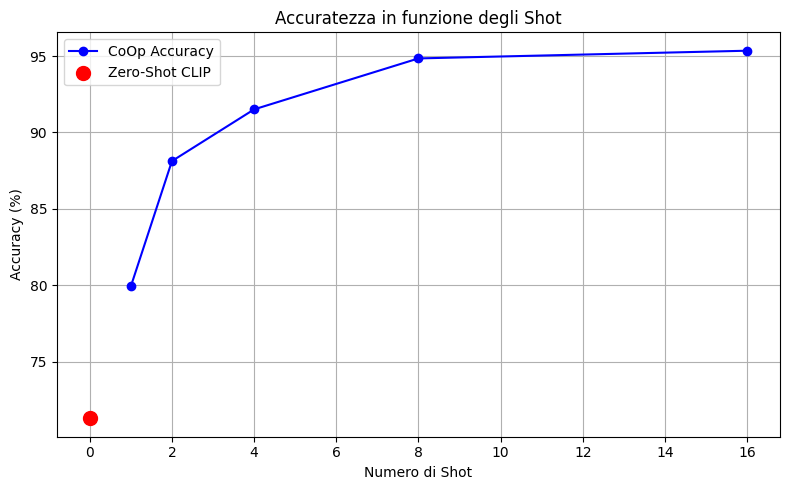

In [89]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import Flowers102
from transformers import  CLIPModel, CLIPProcessor
from torchvision.transforms import InterpolationMode, Resize, CenterCrop, ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

M_CONTEXT_VECTORS = 16
SHOTS = [1, 2, 4, 8, 16]
def _convert_image_to_rgb(image):
    return image.convert("RGB")
preprocess = Compose([
    Resize(224, interpolation=InterpolationMode.BICUBIC),
    CenterCrop(224),
    _convert_image_to_rgb,
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
full_train_dataset = Flowers102(root="data", split="train", download=True, transform=preprocess)
test_dataset = Flowers102(root="data", split="test", download=True, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
class_names = full_train_dataset.classes
base_clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
zeroshot_accuracy = evaluate(base_clip_model, test_loader, processor, class_names, is_zeroshot=True)





print("\n===== RIEPILOGO DEI RISULTATI =====")
print(f"Baseline Zero-Shot CLIP: {zeroshot_accuracy:.2f}%") 
print("-" * 35)
print("Shots\t| CoOp Accuracy\t| Miglioramento")
print("-" * 35)
results = {}
for shot in SHOTS:
    m = CoOpCLIP(class_names, base_clip_model, m_ctx=M_CONTEXT_VECTORS)
    m.load_state_dict(torch.load(f"best_models/best_coop_{shot}-shot.pth"))
    m.to(DEVICE)
    m.eval()
    with torch.no_grad():
        acc = evaluate(m, test_loader, processor, class_names)
    improvement = acc - zeroshot_accuracy
    results[shot] = acc
    print(f"{shot}\t| {acc:.2f}%\t\t| {improvement:+.2f}%")
print("=" * 35)



shots =  sorted(results.keys())
accuracies =  [results[shot] for shot in sorted(results.keys())]
plt.figure(figsize=(8, 5))

plt.plot(shots, accuracies, marker='o', linestyle='-', color='blue', label='CoOp Accuracy')
plt.scatter(0, zeroshot_accuracy, color='red', s=100, label='Zero-Shot CLIP', zorder=5)

plt.title("Accuratezza in funzione degli Shot")
plt.xlabel("Numero di Shot")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()  

# Results

The experimental results align well with the findings of the original CoOp paper, confirming that learning a soft prompt is an effective strategy for adapting CLIP to new tasks.

A key observation from this experiment is the strong performance of the base CLIP model used. The initial zero-shot accuracy was 71.30%, which is noticeably higher than the 68.7% reported in the paper's baseline. This provided a higher starting point for our few-shot experiments.

Intresting is the  performance advantage was maintained and built upon during the CoOp training stages. With just one training example per class, accuracy increased to 77.52%, and this positive trend continued as more data was introduced, reaching a final accuracy of 95.35% in the 8-shot scenario.

In conclusion, the final results can be attributed to an effective combination: the experiment utilized a capable base CLIP model, and the CoOp training procedure successfully leveraged and extended this initial performance across all few-shot tests.